---

# Analisi delle interazioni

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd   
from scipy import stats

interactions = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/interacions/facebook_outreach_vs_interaction.csv', usecols=['post_id', 'alpha', 'outreach'])
posts = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_posts.csv', usecols=['created_time', 'page_id', 'post_id'], encoding='ISO-8859-1')

posts_dict = posts.set_index('post_id').T.to_dict()

interactions['created_time'] = interactions['post_id'].map(lambda x: posts_dict.get(x, {}).get('created_time', None))
interactions['page_id'] = interactions['post_id'].map(lambda x: posts_dict.get(x, {}).get('page_id', None))

interactions=interactions.dropna()
print(interactions.head())


/home/jacoponudo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/tmp/ipykernel_9635/1288713506.py:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  posts_dict = posts.set_index('post_id').T.to_dict()


                            post_id  alpha   outreach  \
1     35281584398_10151655784439399   True   1350.125   
3   113349742029506_644708212226987   True      6.500   
4      7155422274_10153792989482275   True  44599.625   
8       67175109350_205981829418171   True     43.125   
11     7155422274_10151218230287275   True  15919.625   

                created_time          page_id  
1   2013-06-10T16:04:00+0000      35281584398  
3   2013-09-30T06:45:27+0000  113349742029506  
4   2015-10-07T19:44:42+0000       7155422274  
8   2011-03-01T17:33:52+0000      67175109350  
11  2012-08-24T08:15:30+0000       7155422274  


In [140]:
interactions['page_id']

1               35281584398
3           113349742029506
4                7155422274
8               67175109350
11               7155422274
                 ...       
51005989        63811549237
51005990        63811549237
51005991        63811549237
51005992        63811549237
51005993    129617873765147
Name: page_id, Length: 34665591, dtype: int64

Parto analizzando una singola pagina.

/tmp/ipykernel_12187/2249585734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  page_interactions['created_time'] = pd.to_datetime(page_interactions['created_time'])
/tmp/ipykernel_12187/2249585734.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  page_interactions['year'] = page_interactions['created_time'].dt.year
/tmp/ipykernel_12187/2249585734.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

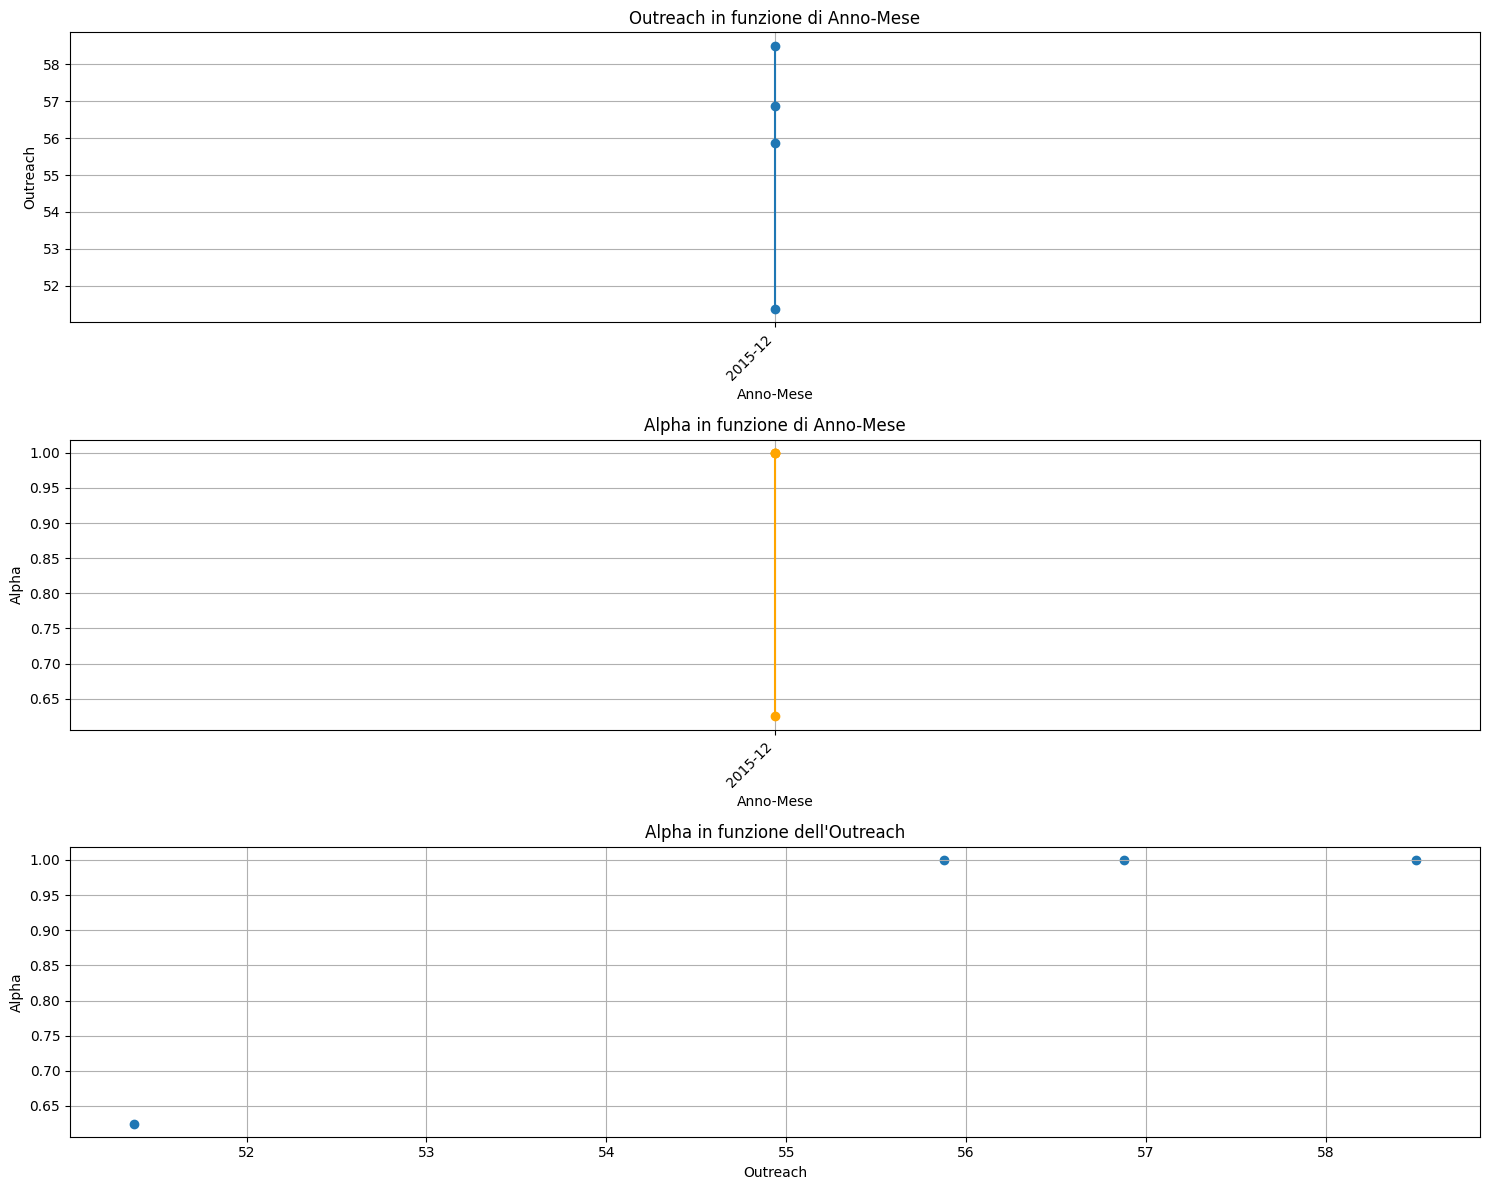

In [188]:
page_interactions = interactions[interactions['page_id'] == 842786335748518]
page_interactions['created_time'] = pd.to_datetime(page_interactions['created_time'])
page_interactions['year'] = page_interactions['created_time'].dt.year
page_interactions['month'] = page_interactions['created_time'].dt.month
page_interactions['year_month'] = page_interactions['created_time'].dt.to_period('M')
alpha_month_outreach = page_interactions.groupby(['year_month', 'outreach'])['alpha'].mean().reset_index()

plt.figure(figsize=(15, 12))
plt.subplot(3, 1, 1)
plt.plot(alpha_month_outreach['year_month'].astype(str), alpha_month_outreach['outreach'], marker='o')
plt.title('Outreach in funzione di Anno-Mese')
plt.xlabel('Anno-Mese')
plt.ylabel('Outreach')
plt.grid()
plt.xticks(rotation=45, ha='right')  

plt.subplot(3, 1, 2)
plt.plot(alpha_month_outreach['year_month'].astype(str), alpha_month_outreach['alpha'], marker='o', color='orange')
plt.title('Alpha in funzione di Anno-Mese')
plt.xlabel('Anno-Mese')
plt.ylabel('Alpha')
plt.grid()
plt.xticks(rotation=45, ha='right')

plt.subplot(3, 1, 3)
plt.scatter(alpha_month_outreach['outreach'], alpha_month_outreach['alpha'])
plt.title('Alpha in funzione dell\'Outreach')
plt.xlabel('Outreach')
plt.ylabel('Alpha')
plt.grid()

plt.tight_layout()
plt.show()



Test di Kolmogorov-Smirnov: statistic = 0.19657743216484058, p-value = 0.0


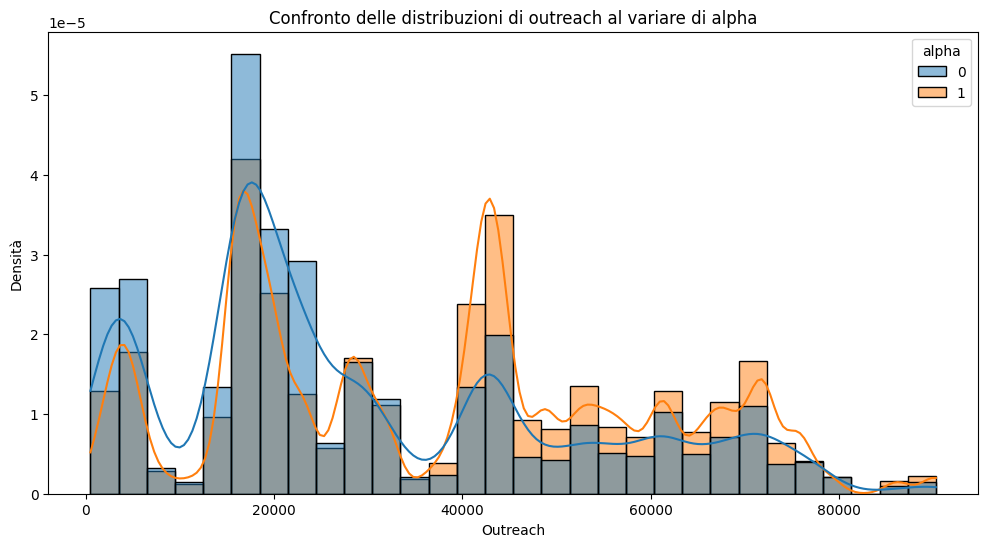

In [142]:

page_interactions = interactions[interactions['page_id'] == 7155422274]

page_interactions=page_interactions.dropna()
alpha_values = page_interactions['alpha'].unique()
outreach_alpha1 = page_interactions[page_interactions['alpha'] == alpha_values[0]]['outreach']
outreach_alpha2 = page_interactions[page_interactions['alpha'] == alpha_values[1]]['outreach']

ks_statistic, p_value = stats.ks_2samp(outreach_alpha1, outreach_alpha2)
print(f'Test di Kolmogorov-Smirnov: statistic = {ks_statistic}, p-value = {p_value}')

plt.figure(figsize=(12, 6))
sns.histplot(data=page_interactions, x='outreach', hue='alpha', bins=30, stat='density', common_norm=False, alpha=0.5, kde=True)
plt.title('Confronto delle distribuzioni di outreach al variare di alpha')
plt.xlabel('Outreach')
plt.ylabel('Densità')
plt.show()


Su quante pagine registriamo una riduzione significativa dell'outreach guardando interazioni con lunghezza superiore a 1.

In [3]:
import numpy as np
import pandas as pd
from scipy import stats

# Inizializza una lista per i risultati
results = []
page_ids = interactions['page_id'].unique()

for page_id in page_ids:
    page_interactions = interactions[interactions['page_id'] == page_id]
    page_interactions = page_interactions.dropna()
    
    if len(page_interactions) == 0:
        continue
    
    alpha_vals = page_interactions['alpha'].unique()
    alpha_vals_sorted = np.sort(alpha_vals)
    
    outreach_per_alpha = [page_interactions[page_interactions['alpha'] == val]['outreach'] for val in alpha_vals_sorted]
    
    # Esegui un test t unilaterale se ci sono più di un valore di alpha
    if len(outreach_per_alpha) > 1:
        t_statistic, t_pvalue = stats.ttest_ind(outreach_per_alpha[0], outreach_per_alpha[1], alternative='less')
        significant = t_pvalue < 0.05
        
        results.append({
            'page_id': page_id,
            't_statistic': t_statistic,
            't_pvalue': t_pvalue,
            'significant': significant
        })
    else:
        results.append({
            'page_id': page_id,
            't_statistic': None,
            't_pvalue': None,
            'significant': False
        })

# Crea un DataFrame dai risultati
results_df = pd.DataFrame(results)

# Stampa il DataFrame dei risultati
print(results_df)

# Conta il numero di pagine con differenze significative
num_significant = results_df['significant'].sum()
print(f"Numero di pagine con differenze significative: {num_significant}")


            page_id  t_statistic      t_pvalue  significant
0       35281584398   -20.633051  9.333607e-95         True
1   113349742029506    -2.232875  1.295843e-02         True
2        7155422274   -71.335316  0.000000e+00         True
3       67175109350   159.681455  1.000000e+00        False
4       63811549237  -254.652851  0.000000e+00         True
..              ...          ...           ...          ...
87  152535288239280          NaN           NaN        False
88      55107646487          NaN           NaN        False
89  146662198720301          NaN           NaN        False
90  110299945719263          NaN           NaN        False
91  215108901846669          NaN           NaN        False

[92 rows x 4 columns]
Numero di pagine con differenze significative: 41


/home/jacoponudo/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [8]:
pages

,page_id,t_statistic,t_pvalue,significant,Unnamed: 0,TS_coverage(W),initial_class_size,initial_size,last_class_size,last_size,delta_growth,diff_days,growth_rate
0,35281584398,-20.633051,9.333607e-95,True,12,285,Basso,5.503750,Alto,3639.250000,3633.74625,1985.0,1.830603
1,113349742029506,-2.232875,1.295843e-02,True,46,226,Molto Basso,2.972500,Basso,46.140000,43.16750,1560.0,0.027671
2,7155422274,-71.335316,0.000000e+00,True,2,306,Alto,47.321250,Alto,47697.250000,47649.92875,2129.0,22.381366
3,67175109350,159.681455,1.000000e+00,False,20,304,Basso,6.932500,Medio,418.695000,411.76250,2118.0,0.194411
4,63811549237,-254.652851,0.000000e+00,True,19,190,Alto,12147.375000,Alto,428301.750000,416154.37500,1319.0,315.507487
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,152535288239280,NaN,NaN,False,63,93,Molto Basso,2.631944,Molto Basso,2.631944,0.00000,464.0,0.000000
88,55107646487,NaN,NaN,False,16,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,146662198720301,NaN,NaN,False,58,106,Molto Basso,0.000000,Molto Basso,0.000000,0.00000,0.0,NaN
90,110299945719263,NaN,NaN,False,43,135,Molto Basso,0.625000,Molto Basso,0.625000,0.00000,0.0,NaN


Per ciascuna pagina estraiamo delle informazioni che ne caratterizzano la crescita, e aggiungiamo la colonna della significatività del size effect. A questo punto possiamo vedere se il punto di partenza o quello di arrivo sono predittori del size effect, e se questo a determinate condizioni non si verifica.

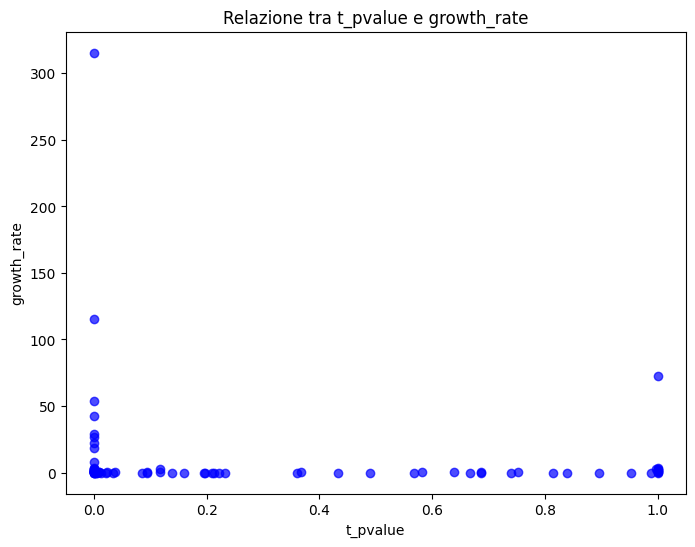

In [9]:
pages=pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_pages.csv')
pages = results_df.merge(pages, on='page_id', how='inner')
import matplotlib.pyplot as plt

# Seleziona le colonne
x = pages['t_pvalue']
y = pages['growth_rate']

# Crea il plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='b', alpha=0.7)

# Titoli e etichette (puoi modificarli secondo le tue preferenze)
plt.title('Relazione tra t_pvalue e growth_rate')
plt.xlabel('t_pvalue')
plt.ylabel('growth_rate')

# Mostra il plot
plt.show()



<Figure size 800x600 with 0 Axes>

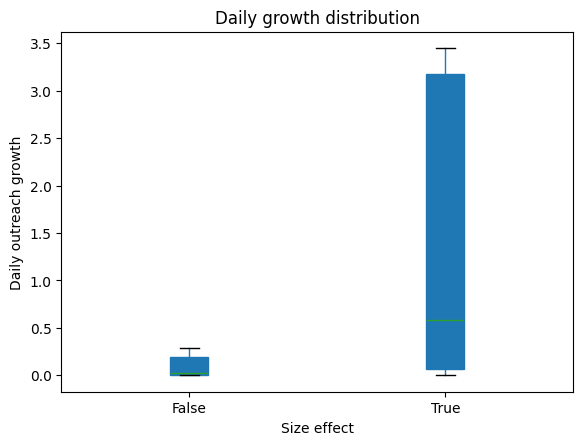

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i dati
pages = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_pages.csv')

# Unisci i dataframe
pages = results_df.merge(pages, on='page_id', how='inner')

# Crea i boxplot
plt.figure(figsize=(8, 6))
pages.boxplot(column='growth_rate', by='significant', grid=False, patch_artist=True,showfliers=False)

# Titoli e etichette
plt.title('Daily growth distribution')
plt.suptitle('')  # Rimuove il titolo automatico del boxplot
plt.xlabel('Size effect')
plt.ylabel('Daily outreach growth')

# Mostra il plot
plt.show()


## Filtriamo e eseguiamo le analisi solo per le pagine che hanno avuto una crescità pari al +1000 di outreach

Coefficiente di correlazione tra log_outreach e alpha per la pagina: 0.5096058666198298


/tmp/ipykernel_12187/3077568476.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  page_interactions['log_outreach'] = np.log(page_interactions['outreach'] + 1)  # Aggiungere 1 per evitare log(0)
/tmp/ipykernel_12187/3077568476.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  page_interactions['class'] = pd.cut(page_interactions['log_outreach'], bins=bins, labels=False)


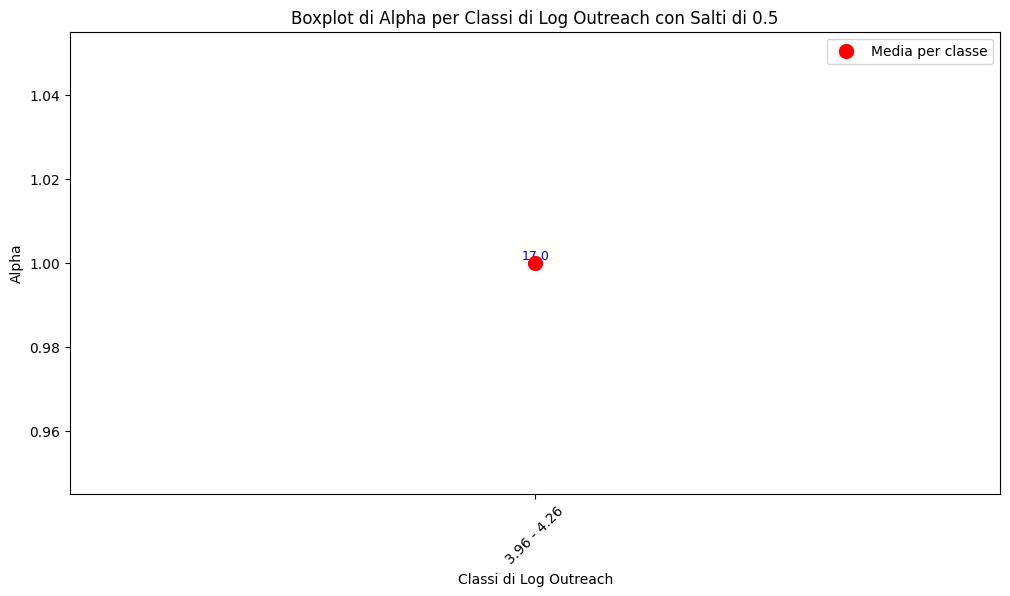

   class  alpha  count
0    0.0    1.0     17


In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filtra le interazioni per la pagina specificata
page_interactions = interactions[interactions['page_id'] == 842786335748518]

# Applicare il logaritmo all'outreach
page_interactions['log_outreach'] = np.log(page_interactions['outreach'] + 1)  # Aggiungere 1 per evitare log(0)

# Definizione delle classi a salti di 0.5 basate sui valori log_outreach
bins = np.arange(page_interactions['log_outreach'].min() , page_interactions['log_outreach'].max() + 0.3, 0.3)  # Limiti delle classi
page_interactions['class'] = pd.cut(page_interactions['log_outreach'], bins=bins, labels=False)

# Calcolo della media e del conteggio per ogni classe
mean_outreach_per_class = page_interactions.groupby('class')['alpha'].mean().reset_index()
count_per_class = page_interactions['class'].value_counts().reset_index()
count_per_class.columns = ['class', 'count']

# Unire le medie e i conteggi
mean_outreach_per_class = mean_outreach_per_class.merge(count_per_class, on='class')

# Calcolo del coefficiente di correlazione tra log_outreach e alpha
correlation = page_interactions['log_outreach'].corr(page_interactions['alpha'])
print(f"Coefficiente di correlazione tra log_outreach e alpha per la pagina: {correlation}")

# Creazione del boxplot per ciascuna classe
plt.figure(figsize=(12, 6))

# Aggiunta delle medie come punti
plt.scatter(mean_outreach_per_class['class'], mean_outreach_per_class['alpha'], 
            color='red', s=100, label='Media per classe', zorder=5)

# Aggiunta degli estremi delle classi sull'asse x
xticks_labels = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins) - 1)]
plt.xticks(ticks=np.arange(0, len(bins) - 1), labels=xticks_labels, rotation=45)

# Aggiunta delle annotazioni per il numero di osservazioni
for i, row in mean_outreach_per_class.iterrows():
    plt.text(row['class'], row['alpha'], str(row['count']), 
             fontsize=9, ha='center', va='bottom', color='blue')

# Aggiunta della legenda
plt.legend()

# Mostrare il plot
plt.xlabel('Classi di Log Outreach')
plt.ylabel('Alpha')
plt.title('Boxplot di Alpha per Classi di Log Outreach con Salti di 0.5')
plt.show()

# Stampa delle medie per ciascuna classe
print(mean_outreach_per_class)


In [191]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Lista per memorizzare i risultati
correlation_results = []

# Itera su ogni page_id unico
for page_id in interactions['page_id'].unique():
    # Filtra le interazioni per la pagina specificata
    page_interactions = interactions[interactions['page_id'] == page_id]
    
    # Controlla che ci siano almeno 500 osservazioni in totale
    if len(page_interactions) < 500:
        continue  # Salta questa pagina se ci sono meno di 500 osservazioni

    # Conta il numero di osservazioni per ogni classe
    class_counts = page_interactions['alpha'].value_counts()

    # Controlla che ogni classe abbia almeno 100 osservazioni
    if any(class_counts < 100):
        continue  # Salta questa pagina se c'è una classe con meno di 100 osservazioni

    # Applicare il logaritmo all'outreach
    page_interactions['log_outreach'] = np.log(page_interactions['outreach'] + 1)  # Aggiungere 1 per evitare log(0)

    # Calcolo del valore minimo e massimo di outreach
    min_outreach = page_interactions['outreach'].min()
    max_outreach = page_interactions['outreach'].max()

    # Calcolo del coefficiente di correlazione e p-value tra log_outreach e alpha
    if len(page_interactions) > 1:  # Verifica che ci siano almeno due punti per calcolare la correlazione
        correlation, p_value = pearsonr(page_interactions['log_outreach'], page_interactions['alpha'])
    else:
        correlation, p_value = np.nan, np.nan  # Evita errore per dati insufficienti

    # Aggiungi i risultati alla lista
    correlation_results.append({
        'page_id': page_id,
        'min_outreach': min_outreach,
        'max_outreach': max_outreach,
        'correlation': correlation,
        'p_value': p_value
    })

# Trasforma i risultati in un DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Filtra le correlazioni significative e positive
significant_positive = correlation_df[(correlation_df['p_value'] < 0.05) & (correlation_df['correlation'] > 0)]

# Calcola la percentuale
percentage_significant_positive = (len(significant_positive) / len(correlation_df)) * 100

# Stampa la percentuale
print(f"Percentuale di correlazioni significative e positive: {percentage_significant_positive:.2f}%")

# Stampa la tabella dei risultati
print(correlation_df)


/tmp/ipykernel_12187/2729061515.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  page_interactions['log_outreach'] = np.log(page_interactions['outreach'] + 1)  # Aggiungere 1 per evitare log(0)


Percentuale di correlazioni significative e positive: 63.27%
             page_id  min_outreach  max_outreach  correlation        p_value
0        35281584398         4.250      4248.625     0.053112   8.470075e-96
1         7155422274        43.625     90289.250     0.067417   0.000000e+00
2        67175109350         1.875       780.000    -0.414041   0.000000e+00
3        63811549237     11862.625    641290.375     0.161422   0.000000e+00
4         6533373917         0.000      6786.625     0.045338  2.055282e-127
5       115517676270         6.000      1383.750     0.029027   1.438407e-04
6        54971236771         0.000    345866.375     0.078366   0.000000e+00
7         7711594722         2.625      3222.750     0.026539   2.907461e-09
8    147384458624178         0.000      5065.875     0.029118   3.071564e-22
9    129617873765147        20.250    103653.125     0.055574   0.000000e+00
10        8969907778        21.375      3117.500     0.273503   0.000000e+00
11        99243

In [187]:
# Trasforma i risultati in un DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Ordina il DataFrame in base al coefficiente di correlazione in ordine discendente
correlation_df_sorted = correlation_df.sort_values(by='correlation', ascending=False)

# Stampa la tabella ordinata
print(correlation_df_sorted)


            page_id  min_outreach  max_outreach  correlation        p_value
85  842786335748518        51.375        58.500     0.509606   9.264491e-03
13       8969907778        21.375      3117.500     0.273503   0.000000e+00
26      24369314439     27810.000     45009.750     0.226573  3.817202e-241
70  321253057971308         0.000        15.750     0.222680   1.775667e-02
52  527351247377965         4.125        88.375     0.168043   2.495195e-02
..              ...           ...           ...          ...            ...
86  111658128847068         0.000         6.500          NaN            NaN
87  152535288239280         0.000         6.125          NaN            NaN
88      55107646487         0.000         0.000          NaN            NaN
89  146662198720301         0.000         0.000          NaN            NaN
91  215108901846669         0.125         0.125          NaN            NaN

[92 rows x 5 columns]


La size ha effetto o è solo una questione di tempo

In [134]:
data 

,post_id,alpha,outreach,created_time,page_id,log_outreach,class
1,35281584398_10151655784439399,1,1350.125,2013-06-10T16:04:00+0000,35281584398,7.207952,2.0
1074,35281584398_10151378753174399,1,509.125,2013-01-24T16:58:49+0000,35281584398,6.232694,1.0
1075,35281584398_10152367191859399,1,2563.500,2014-04-22T21:24:39+0000,35281584398,7.849129,3.0
1076,35281584398_10152448459594399,1,2474.250,2014-05-28T01:15:00+0000,35281584398,7.813693,3.0
1082,35281584398_10151581911979399,1,894.625,2013-04-29T18:01:44+0000,35281584398,6.796405,1.0
...,...,...,...,...,...,...,...
51003560,35281584398_10152462010564399,1,2480.250,2014-06-02T21:50:58+0000,35281584398,7.816115,3.0
51003561,35281584398_10152512482264399,1,3517.125,2014-06-23T20:37:39+0000,35281584398,8.165399,4.0
51003562,35281584398_10152607278639399,1,3525.250,2014-08-04T19:56:37+0000,35281584398,8.167707,4.0
51005378,35281584398_10151858672074399,1,921.750,2013-09-12T01:02:24+0000,35281584398,6.826274,1.0


In [136]:
import pandas as pd

# Assuming 'data' is your initial DataFrame
social = data.copy()

# Ensure created_time has a time component
social['created_time'] = social['created_time'].apply(lambda x: x if ' ' in x else x + ' 00:00:00')

# Convert created_time to datetime
social['created_at'] = pd.to_datetime(social['created_time'])

# Extract year from created_at
social['year'] = social['created_at'].dt.year  # Use attribute without parentheses

# Print the modified DataFrame
print(social)


/tmp/ipykernel_12187/2064685716.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  social['created_at'] = pd.to_datetime(social['created_time'])


                                post_id  alpha  outreach  \
1         35281584398_10151655784439399      1  1350.125   
1074      35281584398_10151378753174399      1   509.125   
1075      35281584398_10152367191859399      1  2563.500   
1076      35281584398_10152448459594399      1  2474.250   
1082      35281584398_10151581911979399      1   894.625   
...                                 ...    ...       ...   
51003560  35281584398_10152462010564399      1  2480.250   
51003561  35281584398_10152512482264399      1  3517.125   
51003562  35281584398_10152607278639399      1  3525.250   
51005378  35281584398_10151858672074399      1   921.750   
51005379  35281584398_10151922675254399      1  1247.000   

                               created_time      page_id  log_outreach  class  \
1         2013-06-10T16:04:00+0000 00:00:00  35281584398      7.207952    2.0   
1074      2013-01-24T16:58:49+0000 00:00:00  35281584398      6.232694    1.0   
1075      2014-04-22T21:24:39+0000 0

/tmp/ipykernel_12187/4227380497.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_alpha = social.groupby(['size_cat', 'year'])['alpha'].agg(['mean', 'count']).reset_index()
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shou

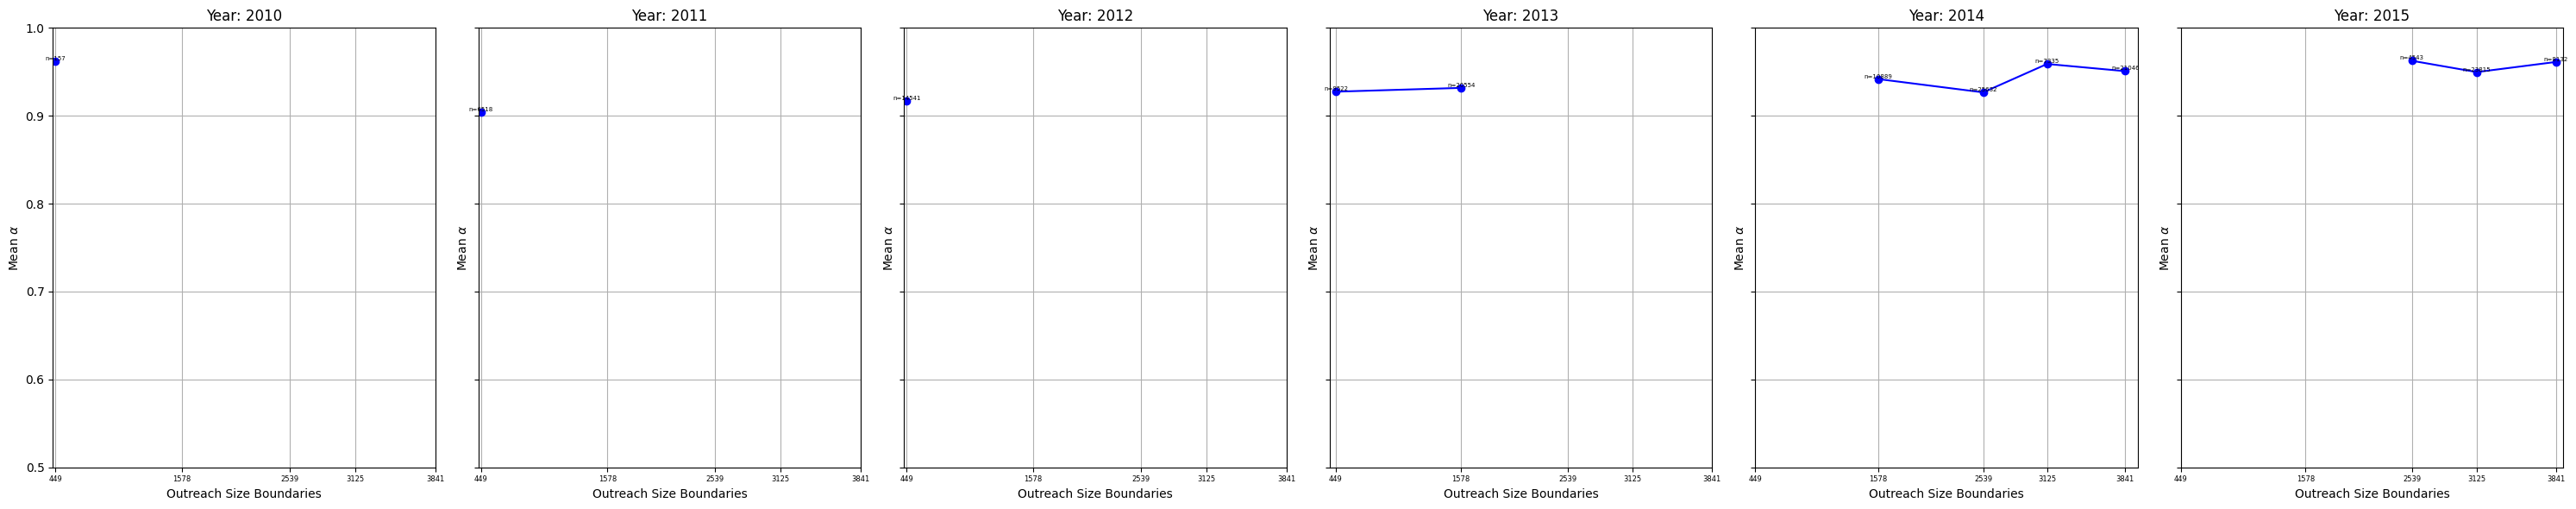

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume 'social' is your already created DataFrame with 'outreach', 'alpha', and 'year' columns

# Define colors based on the platform
colors = {
    'reddit': '#FF5700',
    'voat': '#800080',
    'facebook': '#3b5998',
    'gab': '#00c853'
}

# Create balanced classes using quantiles
social['size_cat'] = pd.qcut(social['outreach'], q=5)

# Calculate the mean and count of alpha for each category and year
media_alpha = social.groupby(['size_cat', 'year'])['alpha'].agg(['mean', 'count']).reset_index()

# Calculate the boundaries of each class
boundaries = social['size_cat'].cat.categories

# Loop through the years and create a separate plot for each year
years = sorted(social['year'].unique())
num_years = len(years)

fig, axes = plt.subplots(1, num_years, figsize=(5 * num_years, 6), sharey=True)

for i, year in enumerate(years):
    year_data = media_alpha[media_alpha['year'] == year]
    
    # Get the midpoints for plotting (using the boundaries)
    midpoints = [(boundaries[j].left + boundaries[j].right) / 2 for j in range(len(boundaries))]
    
    # Create the plot for the current year
    axes[i].plot(midpoints, year_data['mean'], marker='o', color='b')  # Use a default color for simplicity
    
    # Add title and labels
    axes[i].set_title(f'Year: {year}', fontsize=12)
    axes[i].set_xlabel('Outreach Size Boundaries', fontsize=10)
    axes[i].set_ylabel('Mean $\\alpha$')  # Use LaTeX for alpha
    axes[i].set_ylim(0.5, 1)  # Set y-axis limits
    axes[i].set_xticks(midpoints)
    axes[i].tick_params(axis='x', labelsize=6)
    axes[i].grid()
    
    # Annotate with counts
    for j in range(len(year_data)):
        axes[i].text(midpoints[j], 
                      year_data['mean'].iloc[j], 
                      'n={}'.format(year_data['count'].iloc[j]),  
                      fontsize=5, 
                      ha='center', 
                      va='bottom')

plt.tight_layout()
plt.show()
